In [7]:
# Cell 1
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

In [8]:
# Cell 2
import os
import glob

imgdir = 'vehicles/'
notcardir = 'non-vehicles/'
image_types = os.listdir(imgdir)
image_types2 = os.listdir(notcardir)
cars = []
notcars = []
for imtype in image_types:
    cars.extend(glob.glob(imgdir+imtype+'/*'))

for imtype in image_types2:
    notcars.extend(glob.glob(notcardir+imtype+'/*'))

print(len(cars))
print(len(notcars))

with open("notcars.txt",'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

8792
8968


In [9]:
#Cell 3
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def bin_spatial(image, size=(32, 32)):
    color1 = cv2.resize(image[:,:,0], size).ravel()
    color2 = cv2.resize(image[:,:,1], size).ravel()
    color3 = cv2.resize(image[:,:,2], size).ravel()
    
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins)
    ghist = np.histogram(img[:,:,1], bins=nbins)
    bhist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB',spatial_size=(32,32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
    
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img



In [10]:
# Cell 4
def single_img_features(image, color_space='RGB', hist_bins = 32, spatial_size=(32,32), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    # Create a list to append feature vectors to
    file_features = []
    # Iterate through the list of images
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
    
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
        
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    
    if vis == True:
        return np.concatenate(file_features), hog_image
    else:
        return np.concatenate(file_features)

In [11]:

#Cell 5 search windows
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [12]:
#Cell 6 visualize function
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap= 'hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

/Users/ying/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


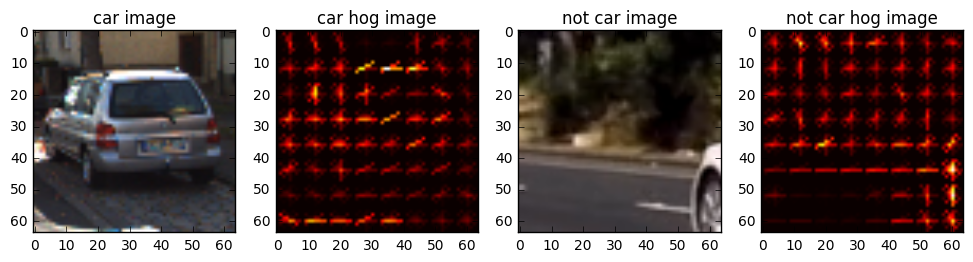

In [13]:
#Cell 7 feature visualization
%matplotlib inline
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

color_space = 'YCrCb'
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car hog image', 'not car image', 'not car hog image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

In [14]:
#Cell 8 feature extraction and Linear SVM
%matplotlib inline

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars#np.array(cars)[random_idxs]
test_notcars = notcars#np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time() - t,'seconds passed')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('feature vectore length', len(X_train[0]))
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')



/Users/ying/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


103.88540697097778 seconds passed
7.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9899
feature vectore length 8460
My SVC predicts:  [ 0.  1.  1.  0.  1.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  0.  0.  0.  0.]
0.0011 Seconds to predict 10 labels with SVC


0.0 1.0
1.2781291007995605 seconds to process an image searching 273 windows
0.0 1.0
1.3803939819335938 seconds to process an image searching 273 windows
0.0 1.0
1.2180089950561523 seconds to process an image searching 273 windows
0.0 1.0
1.2006042003631592 seconds to process an image searching 273 windows
0.0 1.0
1.3651869297027588 seconds to process an image searching 273 windows
0.0 1.0
1.2138941287994385 seconds to process an image searching 273 windows


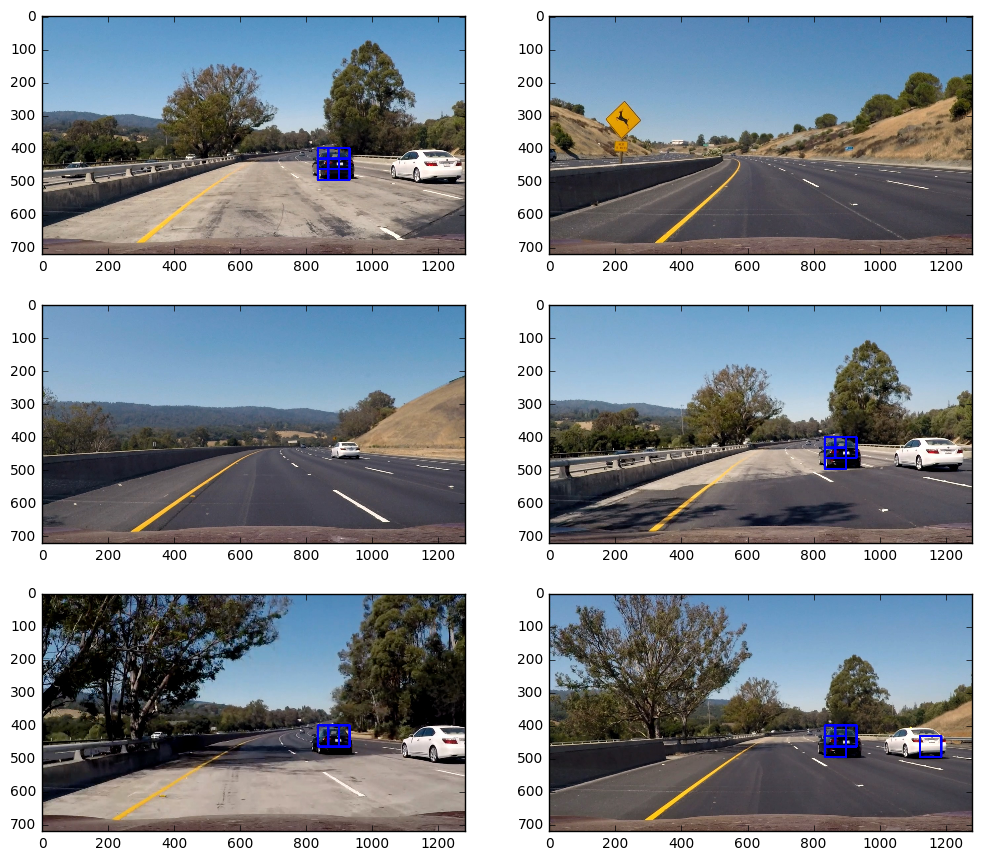

In [47]:
#Cell 9 slide window search
%matplotlib inline

searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656]
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    windows = slide_window(img, x_start_stop = [None, None], y_start_stop=y_start_stop,
                           xy_window=(64,64), xy_overlap=(overlap, overlap))
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process an image searching', len(windows), 'windows')

fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)
    

In [20]:
#Cell 10
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    

/Users/ying/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.9448080062866211 seconds to run, total windows =  912
1.0104060173034668 seconds to run, total windows =  912
0.9075360298156738 seconds to run, total windows =  912
0.9491469860076904 seconds to run, total windows =  912
0.9523599147796631 seconds to run, total windows =  912
1.034024953842163 seconds to run, total windows =  912


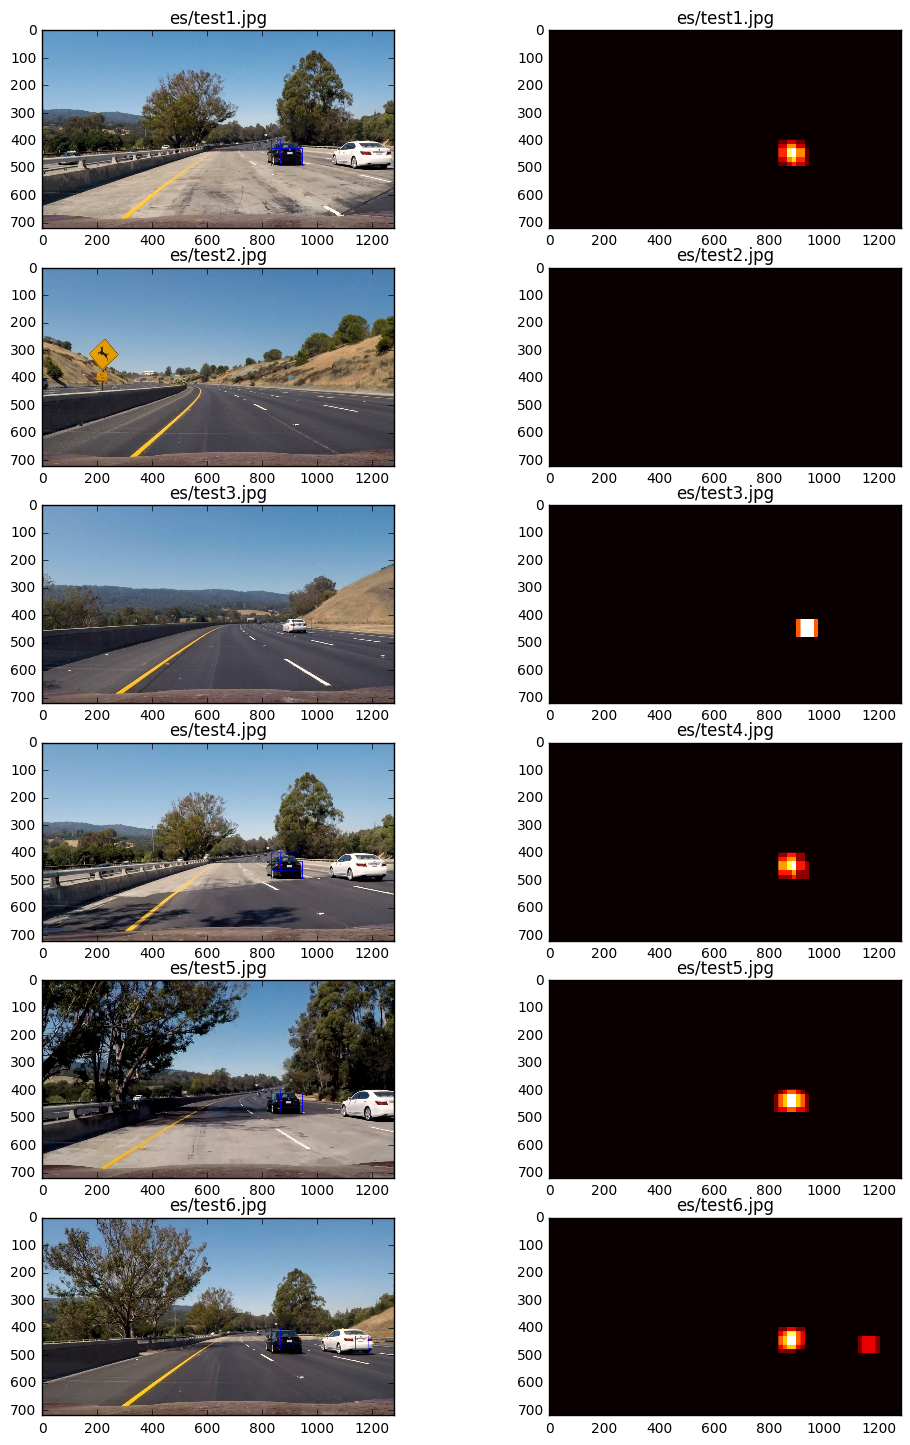

In [21]:
#Cell 11
out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400
ystop =656
scale = 1

for img_src in example_images:
    img_boxes = []
    t=time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv = 'RGB2YCrCb')
    
    if scale !=1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch2.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblock_per_window = (window// pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblock_per_window) // cells_per_step
    nysteps = (nyblocks - nblock_per_window) // cells_per_step
    
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblock_per_window, xpos:xpos+nblock_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblock_per_window, xpos:xpos+nblock_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblock_per_window, xpos:xpos+nblock_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window],(64,64))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart), (0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
            
    print(time.time()-t, 'seconds to run, total windows = ', count)
    
    out_images.append(draw_img)
                                 
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
                                 
    out_images.append(heatmap)    
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

fig = plt.figure(figsize=(12,24))
visualize(fig,8,2,out_images,out_titles)






        

In [52]:
#Cell 12
def find_cars(img, scale):
    
 


    #ystart = 400
    #ystop =656


    
    draw_img = np.copy(img)

    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv = 'RGB2YCrCb')

    if scale !=1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch2.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblock_per_window = (window// pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblock_per_window) // cells_per_step
    nysteps = (nyblocks - nblock_per_window) // cells_per_step


    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            hog_feat1 = hog1[ypos:ypos+nblock_per_window, xpos:xpos+nblock_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblock_per_window, xpos:xpos+nblock_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblock_per_window, xpos:xpos+nblock_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window],(96,96))

            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart), (0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    return draw_img, heatmap, img_boxes







In [53]:
#Cell 13

from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_bboxes(img, labels):
    
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
                   
        bbox = ((np.min(nonzerox),np.min(nonzeroy)),(np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    return img


    

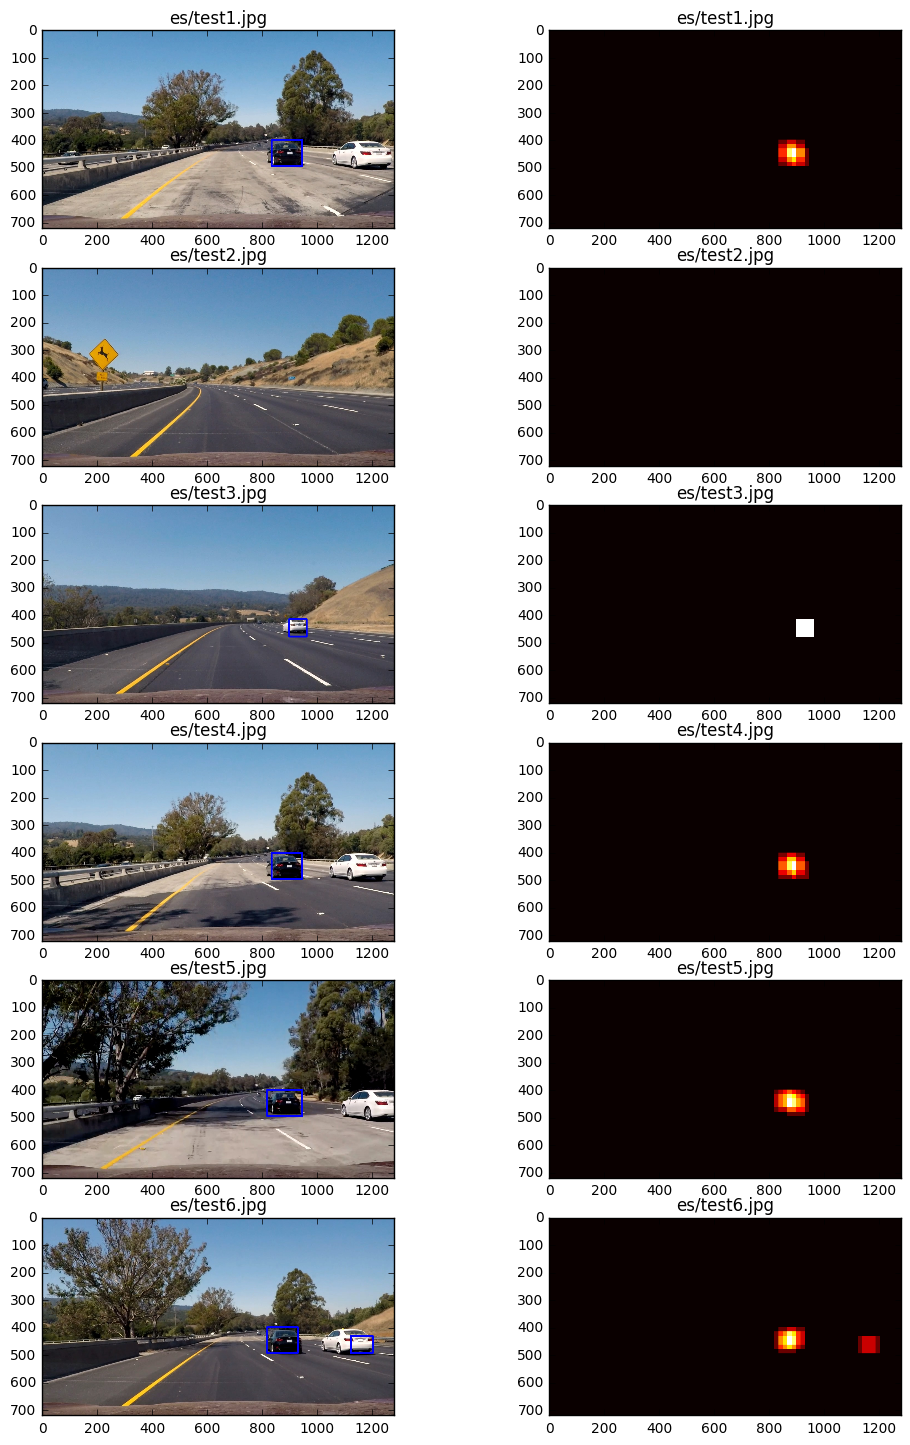

In [54]:
# Cell 14
out_images = []
out_maps = []


ystart = 400
ystop =656
scale = 1


for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    
    draw_img = draw_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [25]:
#Cell 15
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


In [80]:
# Cell 16

def process_image(img):
    
    out_img, heat_map = find_cars(img, scale)
   
    # Apply threshold to help remove false positives
    heat_map = apply_threshold(heat_map,1)

    labels = label(heat_map)
    
    draw_img = draw_bboxes(np.copy(img), labels)
    return draw_img

In [81]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'project_no_filter.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)



[MoviePy] >>>> Building video project_no_filter.mp4
[MoviePy] Writing video project_no_filter.mp4


100%|█████████▉| 1260/1261 [24:07<00:01,  1.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_no_filter.mp4 



In [ ]:
HTML("""
<video width="960" height="540" controls>
<source src="{0}">
</video?
""".format(test_output))